In [1]:
from cvxpy import *
import numpy as np
import scipy.spatial.distance as sdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import sklearn.metrics as sk
from sklearn import decomposition
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
X = np.fromfile("bb_ly_sincos.dat")
X = np.reshape(X, [10010, 512])
NMI_set = []
ET_set = []
data_labels = []
for i in range(10):
    for j in range(100):
        data_labels.append(i)
data_labels = np.asarray(data_labels)
label_num = 1

In [3]:
X0 = np.array(X[0:1000:10])
X1 = np.array(X[1000:2000:10])
X2 = np.array(X[2000:3000:10])
X3 = np.array(X[3000:4000:10])
X4 = np.array(X[4000:5000:10])
X5 = np.array(X[5000:6000:10])
X6 = np.array(X[6000:7000:10])
X7 = np.array(X[7000:8000:10])
X8 = np.array(X[8000:9000:10])
X9 = np.array(X[9000:10000:10])

X0_set = X0 
X1_set = np.concatenate((X0_set, X1), axis=0) 
X2_set = np.concatenate((X1_set, X2), axis=0)
X3_set = np.concatenate((X2_set, X3), axis=0) 
X4_set = np.concatenate((X3_set, X4), axis=0)
X5_set = np.concatenate((X4_set, X5), axis=0)
X6_set = np.concatenate((X5_set, X6), axis=0)
X7_set = np.concatenate((X6_set, X7), axis=0)
X8_set = np.concatenate((X7_set, X8), axis=0)
X9_set = np.concatenate((X8_set, X9), axis=0)


X_all_orig = np.array([X0_set,X1_set,X2_set,X3_set,X4_set,
                 X5_set,X6_set,X7_set,X8_set,X9_set])

In [6]:
def my_hybrid_clustering(mix_set):
    ## Handles increasing dataset size and their labels
    global label_num, data_labels
    Xassign = data_labels[:100*label_num]
    start = time.time()
    ## Optimization
    A = mix_set.T
    Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
    # print('Calculating coefficients and performing optimization...')
    for i in range(np.shape(A)[1]):
        gamma = Parameter(nonneg=True)
        constraints = None
        x = Variable(np.shape(A)[1])
        obj = Minimize(gamma*norm(A*x-A[:,i],2) + norm(x, 2))
        constraints = [x[i] == 0]
        if [constraints == None]:
            prob = Problem(obj)
        else:
            prob = Problem(obj,constraints)
        ## From the original code
        gamma.value = 0.025
        prob.solve(solver='SCS')
        
        Coeff[:,i] = np.transpose(x.value)
    # print('Done!')
    # 
    # print('Extra steps (abs/sym)...')
    Coeff = np.abs(Coeff)
    Coeff = Coeff + np.transpose(Coeff)
    # print('Done!')
    ## Spectral begins here
    x = mix_set.T
    sigma = 2.0
    # print('Calculating pairwise distance matrix...')
    Xdist = sdist.squareform(sdist.pdist(np.transpose(x)))
    # print('Done!')
    ## Set affinity scaling factor
    # sigma = float(input("Sigma: "))
    ## Calculate affinities
    # print('Calculating affinities...')
    Xaff = np.exp((-1.0*np.power(Xdist,2))/(2.0 * np.power(sigma,2)))
    Xaff[range(len(Xaff)),range(len(Xaff))] = 0.0
    # print('Done!')
    # print('Multiplying coefficients by affinities...')
    Xaff = np.matmul(Coeff, Xaff)
    # print('Done!')
    ## Get row sums
    Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))
    ## Normalization
    # print('Normalizing...')
    Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)
    # print('Done!')
    ## Decomposition
    # print('Calculating eigen decomposition...')
    Evals, Evecs = np.linalg.eigh(Xnorm)
    # print('Done!')

    ## Perform clustering
    # print('Clustering...')
    if label_num == 1:
        Xnew = Evecs[:,[-1]]
    elif label_num ==2:
        Xnew = Evecs[:,[-1,-2,-3]]
    elif label_num ==3:
        Xnew = Evecs[:,[-1,-2,-3,-4]]
    elif label_num ==4:
        Xnew = Evecs[:,[-1,-2,-3,-4,-5]]
    elif label_num ==5:
        Xnew = Evecs[:,[-1,-2,-3,-4,-5]]
    elif label_num ==6:
        Xnew = Evecs[:,[-1,-2,-3,-4,-5,-6]]
    elif label_num ==7:
        Xnew = Evecs[:,[-1,-2,-3,-4,-5,-6,-7]]
    elif label_num ==8:
        Xnew = Evecs[:,[-1,-2,-3,-4,-5,-6,-7,-8]]
    elif label_num ==9:
        Xnew = Evecs[:,[-1,-2,-3,-4,-5,-6,-7,-8,-9]]
    else:
        Xnew = Evecs[:,[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]]

    kmeans = KMeans(n_clusters=label_num).fit(Xnew)
    # print('Done!')
    end = time.time()
    ## If you want it on the PCA projection...
    pca = decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(x.T)
    color = ['xkcd:red','xkcd:blue','xkcd:green','xkcd:orange','xkcd:purple','xkcd:brown','xkcd:lime green','xkcd:cyan','xkcd:pink','xkcd:magenta']
    plt.scatter(X_pca[:, 0], X_pca[:, 1],
               color=[color[i] for i in Xassign.astype(int)],
               s=20)
    plt.title('Ground-truth')
    plt.show()
    plt.scatter(X_pca[:, 0], X_pca[:, 1],
               color=[color[i] for i in kmeans.labels_.astype(int)],
               s=20)
    plt.title('Hybrid Clustering')
    plt.show()
    
    ## Let's quantify the performance
    if label_num>1:
        jointPDF = np.zeros([label_num,label_num])
        for x in range(len(Xassign)):
            jointPDF[Xassign[x],kmeans.labels_[x]] += 1
        jointPDF /= len(Xassign)
        jointPDF += 0.000000000000001
        # marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
        plt.imshow(jointPDF)
        plt.title('Mutual Information')
        plt.show()
        NMI_set.append(sk.normalized_mutual_info_score(Xassign,kmeans.labels_))
        print('NMI: ' + str(sk.normalized_mutual_info_score(Xassign,kmeans.labels_)))

    ET = end - start
    ET_set.append(ET)
    print('Elapsed time: ' + str(ET))
    label_num+=1

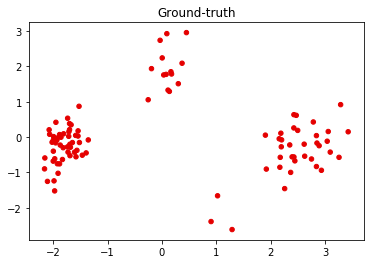

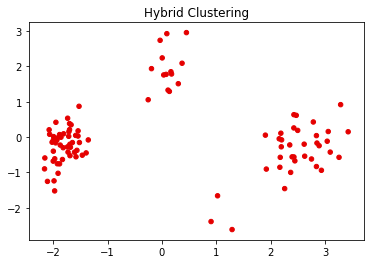

Elapsed time: 24.093827962875366


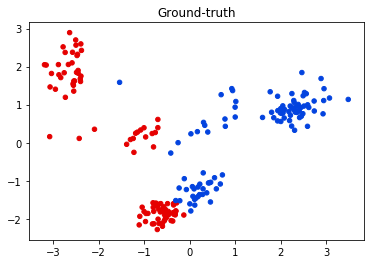

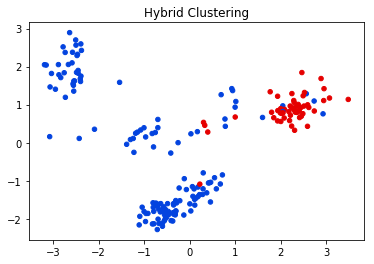

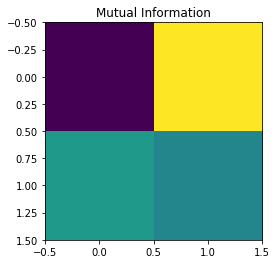

NMI: 0.3747631518991651
Elapsed time: 93.21863102912903


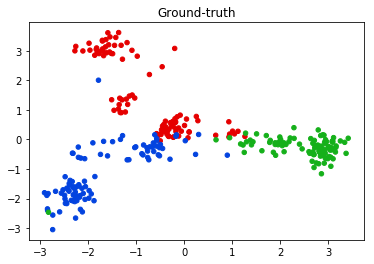

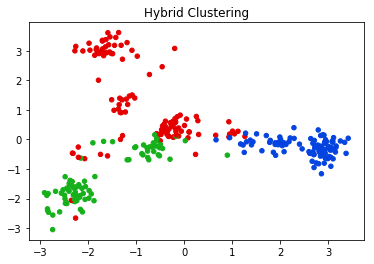

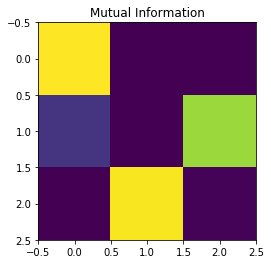

NMI: 0.8510850660581136
Elapsed time: 228.5632700920105


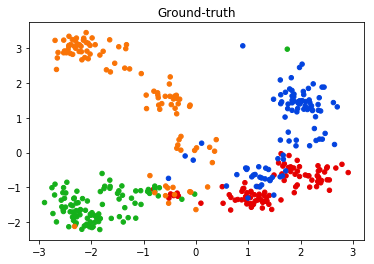

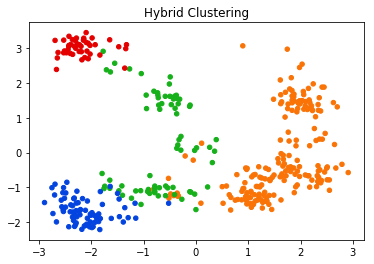

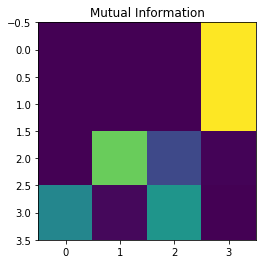

NMI: 0.6809085475957903
Elapsed time: 539.636640548706


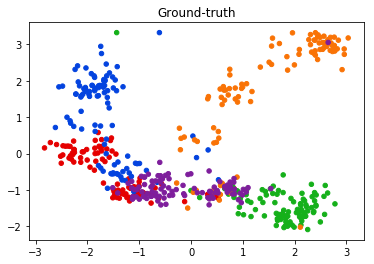

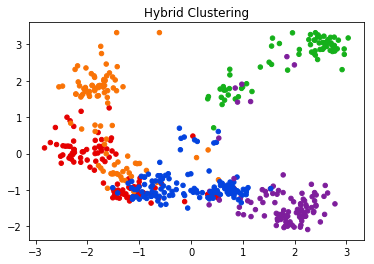

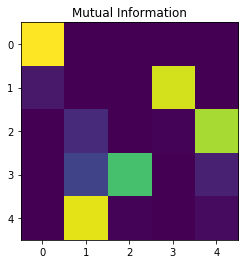

NMI: 0.788981284740898
Elapsed time: 851.8074383735657


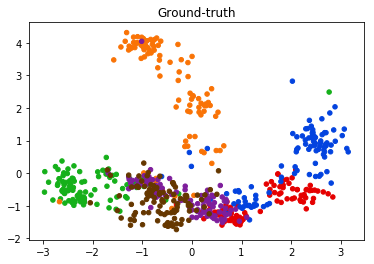

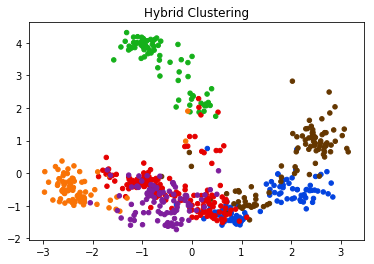

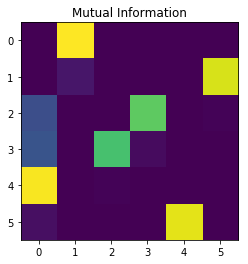

NMI: 0.8262945510095802
Elapsed time: 1268.1067581176758


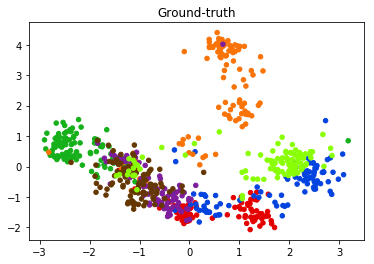

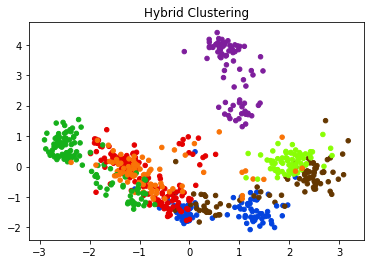

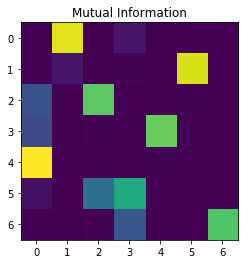

NMI: 0.7552584509912594
Elapsed time: 1745.2199528217316


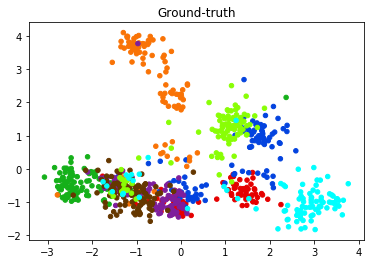

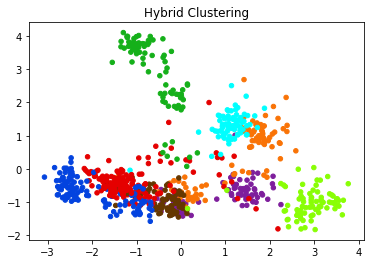

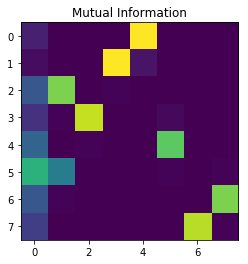

NMI: 0.7258975466743796
Elapsed time: 2327.626054048538


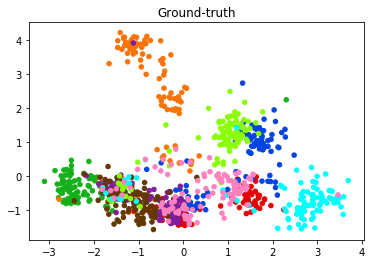

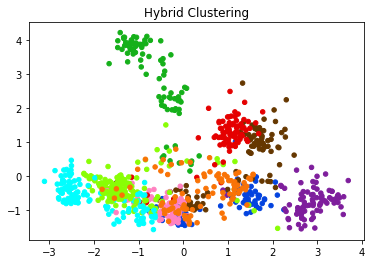

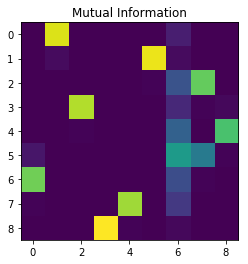

NMI: 0.7639240912441735
Elapsed time: 3085.5577783584595


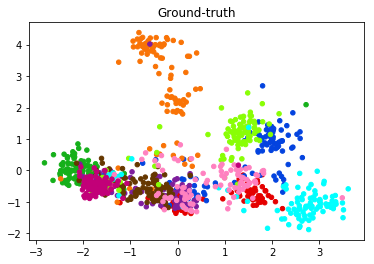

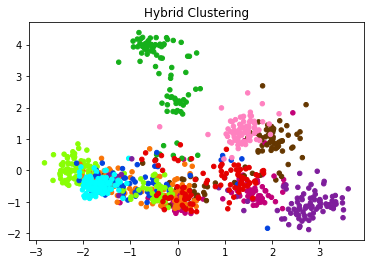

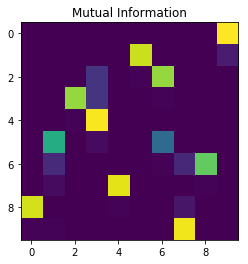

NMI: 0.8487699146525495
Elapsed time: 3690.402846813202


In [7]:
for my_set in X_all_orig:
    my_hybrid_clustering(my_set)

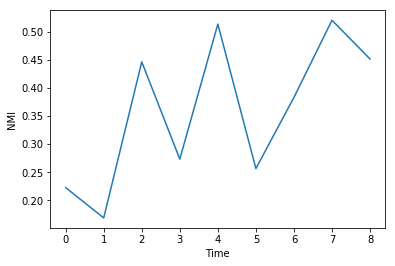

5.151983745495479
51.51983745495479


In [19]:
label_num=1
NMI_plot = np.asarray(NMI_set)
plt.ylabel('NMI')
plt.xlabel('Time')
plt.plot(NMI_plot)
plt.show()
ET_set = np.asarray(np.abs(ET_set))
ET_avg = np.sum(ET_set)/10.0/60.0
print(ET_avg)
print(ET_avg*10.0)

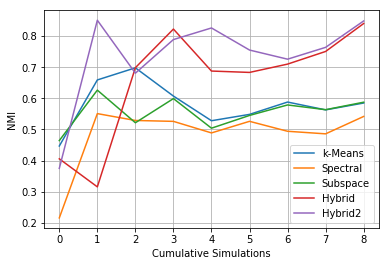

In [10]:

NMI_set_kmeans = [0.4467172919391228,
0.6591317848514536,
0.6981013332123751,
0.6072535979386398,
0.5280178456489844,
0.5484288000593716,
0.5880554801929031,
0.5629041336318281,
0.5849387416179088]
NMI_set_spectral = [0.2155385622252336,
0.5509063782318182,
0.5288504373057055,
0.525961221538687,
0.4888122734205585,
0.5260718123943454,
0.49410559670091164,
0.48584694032017894,
0.5417611044677174]
NMI_set_subspace = [0.4641451933956232,
0.6263471223761748,
0.5215543110652321,
0.5991757946782881,
0.5040345863878517,
0.5450307540658657,
0.5787161566728455,
0.563506712423619,
0.5875622553016138]
NMI_set_hybrid = [0.4055505810336803,
0.3153822303639715,
0.6984992098752827,
0.8227086918657258,
0.6877278152555529,
0.6833408944386005,
0.7100603194100057,
0.7507086380733639,
0.8405160867323677]
NMI_set_hybrid2 = [ 0.3747631518991651,
0.8510850660581136,
0.6809085475957903,
0.788981284740898,
0.8262945510095802,
0.7552584509912594,
0.7258975466743796,
0.7639240912441735,
0.8487699146525495]
NMI_set = [NMI_set_kmeans, NMI_set_spectral, NMI_set_subspace, NMI_set_hybrid, NMI_set_hybrid2]
NMI_names = ["k-Means", "Spectral", "Subspace", "Hybrid","Hybrid2"]
for nset in NMI_set:
    plt.plot(nset, label=NMI_names[NMI_set.index(nset)])
plt.legend()
plt.grid(b=True)
y_label = plt.ylabel('NMI')
x_label = plt.xlabel('Cumulative Simulations')
plt.xticks(np.arange(0,9))
plt.show()